# Protocol Selection of FedLeak (CenterCrop Generator), Lung & Colon Cancer (LC25000)

Here is the protocol selection to decide in which way should FedLeak be transferred.

We evaluate it with ***Lung & Colon Cancer (LC25000)***, with $5$ times sampling batch = $16$, reporting the best results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from train-set, with `shuffle=False`.
- *Way to report*: best PSNRs in $5$ times recovery.

Codes are aligned with `sanity_check_center_crop_LC25000.ipynb`, with two modifications utilized:
- ⭕ Force generating with $224\times224\times3$.
- ⭕ Abort comparing with `upsampling` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, utils, argparse, os
from criteria import *
from utils import upscale, get_resnet18
from centercrop_generator import FedLeak
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:1")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224))
])

dataset = torchvision.datasets.ImageFolder(root="~/data/lung_colon_image_set/", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
loader_iter = iter(trainloader)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

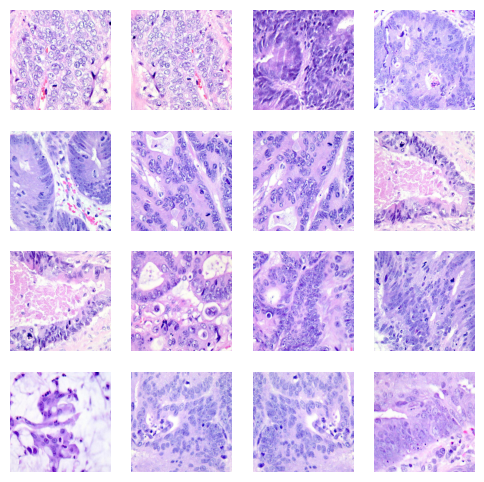

| It: 1 | Loss: -42.7290 | Time:   5.50s |


| It: 1001 | Loss: -58.3365 | Time: 705.74s |


| It: 2001 | Loss: -59.4382 | Time: 780.53s |


| It: 3001 | Loss: -60.2166 | Time: 779.56s |


| It: 4001 | Loss: -60.6366 | Time: 778.89s |


| It: 5001 | Loss: -60.9197 | Time: 779.89s |


| It: 6001 | Loss: -61.1414 | Time: 778.35s |


| It: 7001 | Loss: -61.2796 | Time: 778.53s |


| It: 8001 | Loss: -61.3695 | Time: 777.56s |


| It: 9001 | Loss: -61.4119 | Time: 777.97s |


| It: 1 | Loss: -41.7038 | Time:   0.84s |


| It: 1001 | Loss: -58.6602 | Time: 777.52s |


| It: 2001 | Loss: -59.7480 | Time: 778.72s |


| It: 3001 | Loss: -60.4274 | Time: 777.01s |


| It: 4001 | Loss: -60.7627 | Time: 777.82s |


| It: 5001 | Loss: -61.0158 | Time: 779.76s |


| It: 6001 | Loss: -61.1999 | Time: 781.18s |


| It: 7001 | Loss: -61.3354 | Time: 780.69s |


| It: 8001 | Loss: -61.4211 | Time: 780.58s |


| It: 9001 | Loss: -61.4647 | Time: 780.65s |


| It: 1 | Loss: -41.0692 | Time:   0.84s |


| It: 1001 | Loss: -58.6507 | Time: 780.36s |


| It: 2001 | Loss: -59.8387 | Time: 779.57s |


| It: 3001 | Loss: -60.5526 | Time: 780.65s |


| It: 4001 | Loss: -60.9297 | Time: 780.15s |


| It: 5001 | Loss: -61.1632 | Time: 780.18s |


| It: 6001 | Loss: -61.3059 | Time: 779.93s |


| It: 7001 | Loss: -61.4299 | Time: 780.26s |


| It: 8001 | Loss: -61.5037 | Time: 780.43s |


| It: 9001 | Loss: -61.5395 | Time: 780.54s |


| It: 1 | Loss: -41.1364 | Time:   0.85s |


| It: 1001 | Loss: -57.6646 | Time: 780.13s |


| It: 2001 | Loss: -59.2047 | Time: 780.06s |


| It: 3001 | Loss: -60.0530 | Time: 780.73s |


| It: 4001 | Loss: -60.5486 | Time: 780.13s |


| It: 5001 | Loss: -60.8478 | Time: 781.90s |


| It: 6001 | Loss: -61.0564 | Time: 781.04s |


| It: 7001 | Loss: -61.2094 | Time: 781.20s |


| It: 8001 | Loss: -61.3023 | Time: 780.40s |


| It: 9001 | Loss: -61.3510 | Time: 780.47s |


| It: 1 | Loss: -43.1629 | Time:   0.81s |


| It: 1001 | Loss: -58.7536 | Time: 780.39s |


| It: 2001 | Loss: -59.9017 | Time: 779.73s |


| It: 3001 | Loss: -60.4703 | Time: 780.20s |


| It: 4001 | Loss: -60.8403 | Time: 780.30s |


| It: 5001 | Loss: -61.0649 | Time: 781.52s |


| It: 6001 | Loss: -61.2410 | Time: 781.44s |


| It: 7001 | Loss: -61.3478 | Time: 780.25s |


| It: 8001 | Loss: -61.4237 | Time: 780.94s |


| It: 9001 | Loss: -61.4634 | Time: 780.07s |


BEST PSNR: 14.3228
MEDIAN PSNR: 13.6392
ALL PSNR: [13.9051, 14.0140, 14.3228, 13.6642, 13.6642]


<Figure size 400x300 with 0 Axes>

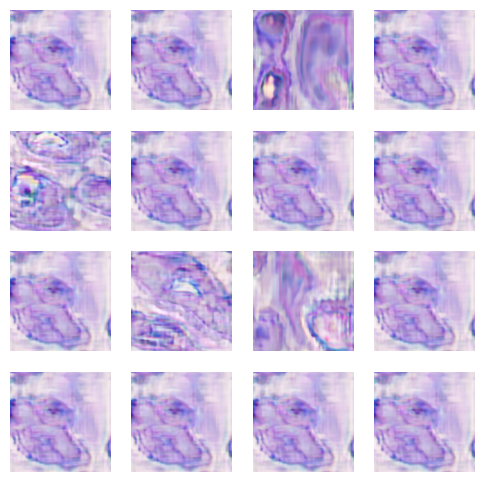

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

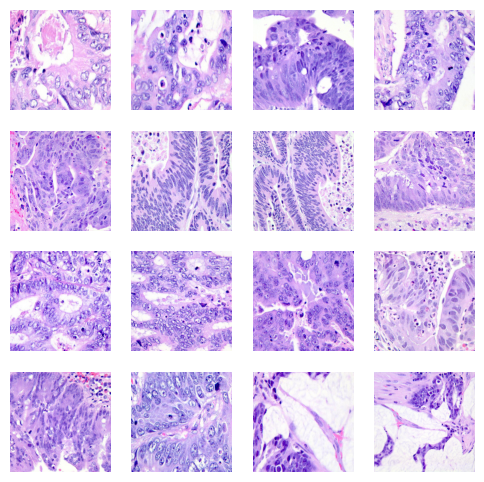

| It: 1 | Loss: -40.4666 | Time:   0.74s |


| It: 1001 | Loss: -57.3790 | Time: 778.46s |


| It: 2001 | Loss: -59.1134 | Time: 780.36s |


| It: 3001 | Loss: -59.9641 | Time: 779.26s |


| It: 4001 | Loss: -60.3966 | Time: 780.64s |


| It: 5001 | Loss: -60.7482 | Time: 780.14s |


| It: 6001 | Loss: -60.9873 | Time: 779.70s |


| It: 7001 | Loss: -61.1497 | Time: 780.75s |


| It: 8001 | Loss: -61.2594 | Time: 779.70s |


| It: 9001 | Loss: -61.3193 | Time: 781.66s |


| It: 1 | Loss: -41.2752 | Time:   0.82s |


| It: 1001 | Loss: -58.1562 | Time: 780.80s |


| It: 2001 | Loss: -59.5665 | Time: 780.46s |


| It: 3001 | Loss: -60.2053 | Time: 780.21s |


| It: 4001 | Loss: -60.6091 | Time: 780.80s |


| It: 5001 | Loss: -60.9548 | Time: 781.33s |


| It: 6001 | Loss: -61.1394 | Time: 780.17s |


| It: 7001 | Loss: -61.3057 | Time: 780.31s |


| It: 8001 | Loss: -61.3991 | Time: 780.09s |


| It: 9001 | Loss: -61.4450 | Time: 781.05s |


| It: 1 | Loss: -39.9466 | Time:   0.84s |


| It: 1001 | Loss: -56.4037 | Time: 779.54s |


| It: 2001 | Loss: -57.9305 | Time: 780.33s |


| It: 3001 | Loss: -59.2392 | Time: 780.05s |


| It: 4001 | Loss: -59.9976 | Time: 780.34s |


| It: 5001 | Loss: -60.4773 | Time: 781.64s |


| It: 6001 | Loss: -60.7845 | Time: 780.74s |


| It: 7001 | Loss: -60.9947 | Time: 780.14s |


| It: 8001 | Loss: -61.1279 | Time: 780.35s |


| It: 9001 | Loss: -61.1936 | Time: 780.95s |


| It: 1 | Loss: -40.5397 | Time:   0.86s |


| It: 1001 | Loss: -57.5273 | Time: 779.47s |


| It: 2001 | Loss: -59.1492 | Time: 779.40s |


| It: 3001 | Loss: -60.0029 | Time: 779.55s |


| It: 4001 | Loss: -60.5578 | Time: 780.32s |


| It: 5001 | Loss: -60.8340 | Time: 779.47s |


| It: 6001 | Loss: -61.0572 | Time: 779.19s |


| It: 7001 | Loss: -61.2160 | Time: 780.73s |


| It: 8001 | Loss: -61.3194 | Time: 780.76s |


| It: 9001 | Loss: -61.3708 | Time: 780.47s |


| It: 1 | Loss: -41.9808 | Time:   0.84s |


| It: 1001 | Loss: -55.8277 | Time: 780.19s |


| It: 2001 | Loss: -57.9848 | Time: 780.76s |


| It: 3001 | Loss: -59.3985 | Time: 778.61s |


| It: 4001 | Loss: -60.0824 | Time: 780.85s |


| It: 5001 | Loss: -60.5599 | Time: 778.74s |


| It: 6001 | Loss: -60.8221 | Time: 779.83s |


| It: 7001 | Loss: -61.0291 | Time: 780.84s |


| It: 8001 | Loss: -61.1536 | Time: 780.91s |


| It: 9001 | Loss: -61.2161 | Time: 780.38s |


BEST PSNR: 13.4252
MEDIAN PSNR: 11.7692
ALL PSNR: [13.4252, 8.9673, 12.6102, 10.7490, 10.7490]


<Figure size 400x300 with 0 Axes>

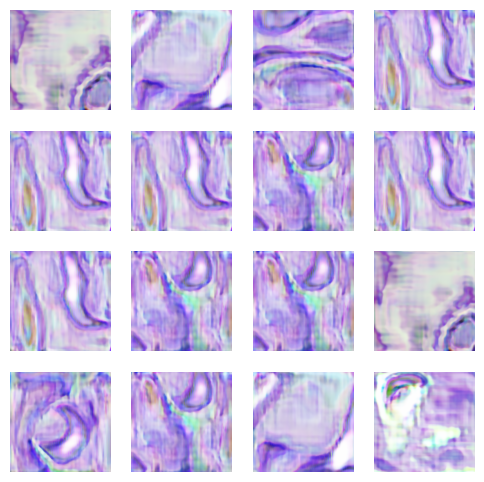

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

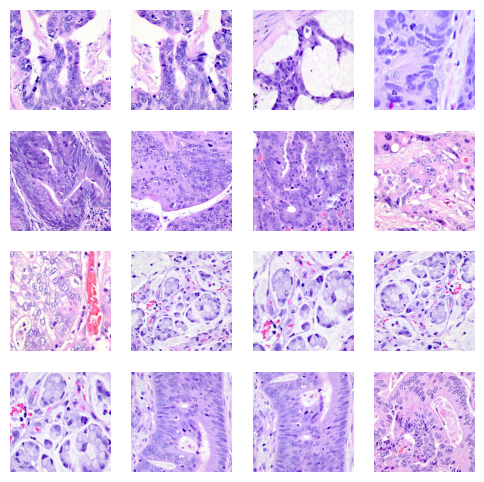

| It: 1 | Loss: -40.0478 | Time:   0.73s |


| It: 1001 | Loss: -58.1462 | Time: 778.20s |


| It: 2001 | Loss: -59.3045 | Time: 778.70s |


| It: 3001 | Loss: -59.9686 | Time: 778.63s |


| It: 4001 | Loss: -60.4884 | Time: 779.19s |


| It: 5001 | Loss: -60.7561 | Time: 780.37s |


| It: 6001 | Loss: -60.9839 | Time: 779.54s |


| It: 7001 | Loss: -61.1377 | Time: 780.09s |


| It: 8001 | Loss: -61.2405 | Time: 779.81s |


| It: 9001 | Loss: -61.2880 | Time: 780.35s |


| It: 1 | Loss: -42.8779 | Time:   0.85s |


| It: 1001 | Loss: -58.7722 | Time: 779.76s |


| It: 2001 | Loss: -59.8832 | Time: 779.24s |


| It: 3001 | Loss: -60.5247 | Time: 779.74s |


| It: 4001 | Loss: -60.7997 | Time: 780.20s |


| It: 5001 | Loss: -61.0691 | Time: 779.87s |


| It: 6001 | Loss: -61.2021 | Time: 779.39s |


| It: 7001 | Loss: -61.3280 | Time: 780.20s |


| It: 8001 | Loss: -61.4050 | Time: 780.87s |


| It: 9001 | Loss: -61.4425 | Time: 779.01s |


| It: 1 | Loss: -42.7811 | Time:   0.84s |


| It: 1001 | Loss: -58.8544 | Time: 780.47s |


| It: 2001 | Loss: -60.1466 | Time: 780.34s |


| It: 3001 | Loss: -60.7155 | Time: 779.31s |


| It: 4001 | Loss: -61.0493 | Time: 779.99s |


| It: 5001 | Loss: -61.2324 | Time: 779.91s |


| It: 6001 | Loss: -61.3563 | Time: 780.86s |


| It: 7001 | Loss: -61.4589 | Time: 781.03s |


| It: 8001 | Loss: -61.5204 | Time: 779.70s |


| It: 9001 | Loss: -61.5535 | Time: 780.91s |


| It: 1 | Loss: -41.2441 | Time:   0.85s |


| It: 1001 | Loss: -58.1501 | Time: 780.38s |


| It: 2001 | Loss: -59.3083 | Time: 780.79s |


| It: 3001 | Loss: -60.0502 | Time: 781.43s |


| It: 4001 | Loss: -60.5696 | Time: 779.80s |


| It: 5001 | Loss: -60.8433 | Time: 778.88s |


| It: 6001 | Loss: -61.0579 | Time: 780.42s |


| It: 7001 | Loss: -61.2061 | Time: 780.06s |


| It: 8001 | Loss: -61.2974 | Time: 780.84s |


| It: 9001 | Loss: -61.3448 | Time: 779.80s |


| It: 1 | Loss: -44.7630 | Time:   0.84s |


| It: 1001 | Loss: -58.3611 | Time: 780.42s |


| It: 2001 | Loss: -59.7014 | Time: 779.26s |


| It: 3001 | Loss: -60.4929 | Time: 780.16s |


| It: 4001 | Loss: -60.8633 | Time: 780.21s |


| It: 5001 | Loss: -61.1130 | Time: 781.33s |


| It: 6001 | Loss: -61.2980 | Time: 781.08s |


| It: 7001 | Loss: -61.3968 | Time: 780.92s |


| It: 8001 | Loss: -61.4705 | Time: 779.36s |


| It: 9001 | Loss: -61.5069 | Time: 779.70s |


BEST PSNR: 12.6815
MEDIAN PSNR: 11.6207
ALL PSNR: [10.4292, 10.7786, 11.5936, 12.6815, 12.6815]


<Figure size 400x300 with 0 Axes>

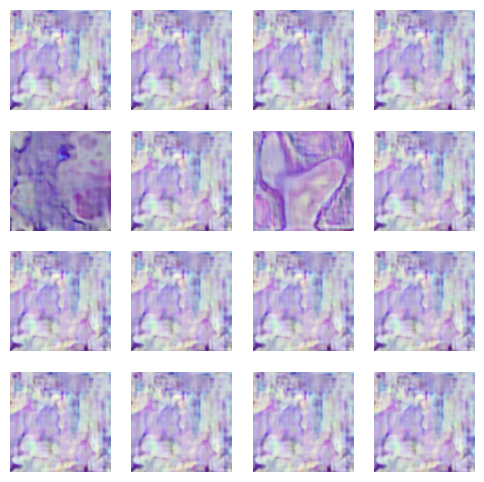

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

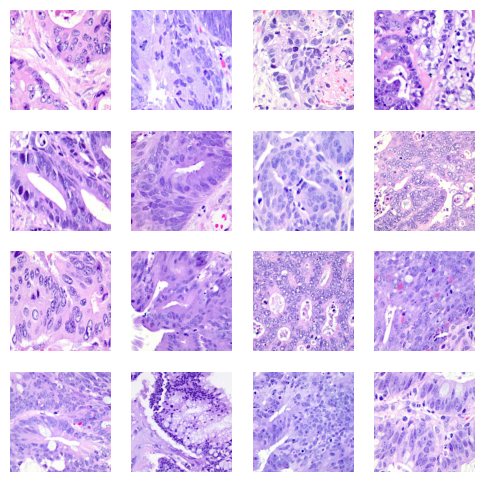

| It: 1 | Loss: -42.3676 | Time:   0.86s |


| It: 1001 | Loss: -58.1585 | Time: 779.09s |


| It: 2001 | Loss: -59.5638 | Time: 779.61s |


| It: 3001 | Loss: -60.3485 | Time: 778.94s |


| It: 4001 | Loss: -60.7317 | Time: 780.47s |


| It: 5001 | Loss: -61.0018 | Time: 778.51s |


| It: 6001 | Loss: -61.1820 | Time: 779.22s |


| It: 7001 | Loss: -61.3054 | Time: 779.84s |


| It: 8001 | Loss: -61.4003 | Time: 779.22s |


| It: 9001 | Loss: -61.4437 | Time: 778.85s |


| It: 1 | Loss: -40.1660 | Time:   0.81s |


| It: 1001 | Loss: -57.8689 | Time: 779.33s |


| It: 2001 | Loss: -59.1962 | Time: 779.82s |


| It: 3001 | Loss: -59.9120 | Time: 780.45s |


| It: 4001 | Loss: -60.4294 | Time: 779.22s |


| It: 5001 | Loss: -60.7585 | Time: 779.56s |


| It: 6001 | Loss: -60.9930 | Time: 780.28s |


| It: 7001 | Loss: -61.1787 | Time: 779.23s |


| It: 8001 | Loss: -61.2789 | Time: 779.09s |


| It: 9001 | Loss: -61.3340 | Time: 781.25s |


| It: 1 | Loss: -40.1498 | Time:   0.85s |


| It: 1001 | Loss: -57.8073 | Time: 779.66s |


| It: 2001 | Loss: -59.7756 | Time: 779.22s |


| It: 3001 | Loss: -60.5210 | Time: 780.43s |


| It: 4001 | Loss: -60.8697 | Time: 779.12s |


| It: 5001 | Loss: -61.1024 | Time: 778.28s |


| It: 6001 | Loss: -61.2816 | Time: 780.62s |


| It: 7001 | Loss: -61.4099 | Time: 779.54s |


| It: 8001 | Loss: -61.4855 | Time: 778.94s |


| It: 9001 | Loss: -61.5244 | Time: 780.26s |


| It: 1 | Loss: -42.8208 | Time:   0.86s |


| It: 1001 | Loss: -57.6628 | Time: 779.30s |


| It: 2001 | Loss: -59.5728 | Time: 780.50s |


| It: 3001 | Loss: -60.4068 | Time: 779.54s |


| It: 4001 | Loss: -60.8043 | Time: 780.48s |


| It: 5001 | Loss: -61.0346 | Time: 779.46s |


| It: 6001 | Loss: -61.2320 | Time: 778.11s |


| It: 7001 | Loss: -61.3565 | Time: 779.02s |


| It: 8001 | Loss: -61.4324 | Time: 780.01s |


| It: 9001 | Loss: -61.4735 | Time: 781.02s |


| It: 1 | Loss: -38.6506 | Time:   0.86s |


| It: 1001 | Loss: -47.9341 | Time: 780.18s |


| It: 2001 | Loss: -55.2388 | Time: 781.04s |


| It: 3001 | Loss: -57.4359 | Time: 780.68s |


| It: 4001 | Loss: -58.4404 | Time: 779.36s |


| It: 5001 | Loss: -59.1559 | Time: 780.74s |


| It: 6001 | Loss: -59.5769 | Time: 780.60s |


| It: 7001 | Loss: -59.8797 | Time: 779.24s |


| It: 8001 | Loss: -60.0728 | Time: 780.53s |


| It: 9001 | Loss: -60.1792 | Time: 780.71s |


BEST PSNR: 13.8226
MEDIAN PSNR: 12.9803
ALL PSNR: [13.6074, 12.8765, 12.8907, 13.8226, 13.8226]


<Figure size 400x300 with 0 Axes>

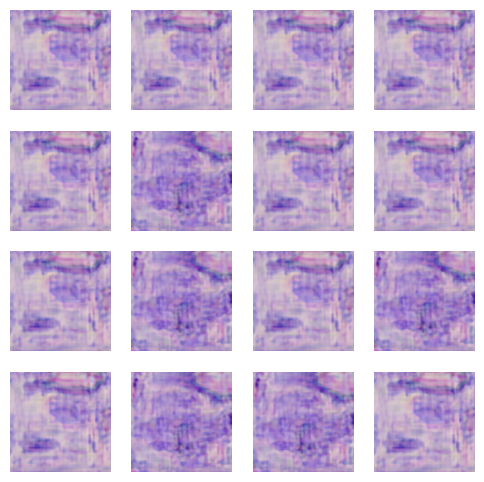

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

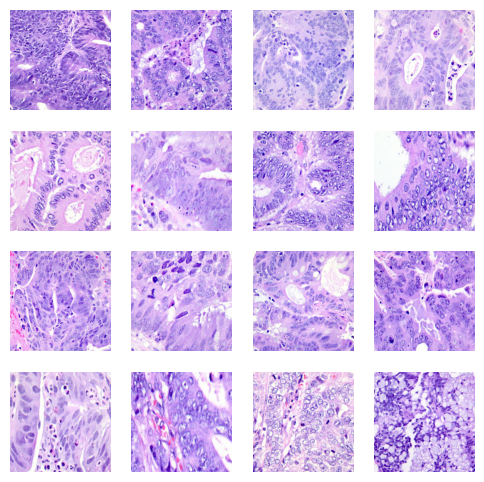

| It: 1 | Loss: -39.4051 | Time:   0.74s |


| It: 1001 | Loss: -57.3991 | Time: 779.61s |


| It: 2001 | Loss: -58.6928 | Time: 780.71s |


| It: 3001 | Loss: -59.5597 | Time: 781.21s |


| It: 4001 | Loss: -60.1515 | Time: 779.81s |


| It: 5001 | Loss: -60.5432 | Time: 780.36s |


| It: 6001 | Loss: -60.8324 | Time: 780.65s |


| It: 7001 | Loss: -61.0321 | Time: 781.18s |


| It: 8001 | Loss: -61.1560 | Time: 781.03s |


| It: 9001 | Loss: -61.2208 | Time: 780.00s |


| It: 1 | Loss: -41.6993 | Time:   0.77s |


| It: 1001 | Loss: -58.2887 | Time: 781.17s |


| It: 2001 | Loss: -59.6464 | Time: 780.72s |


| It: 3001 | Loss: -60.2657 | Time: 780.94s |


| It: 4001 | Loss: -60.6420 | Time: 779.97s |


| It: 5001 | Loss: -60.9425 | Time: 780.74s |


| It: 6001 | Loss: -61.1194 | Time: 781.41s |


| It: 7001 | Loss: -61.2744 | Time: 781.02s |


| It: 8001 | Loss: -61.3594 | Time: 779.96s |


| It: 9001 | Loss: -61.4041 | Time: 780.48s |


| It: 1 | Loss: -40.5832 | Time:   0.82s |


| It: 1001 | Loss: -57.4760 | Time: 781.37s |


| It: 2001 | Loss: -59.5016 | Time: 781.16s |


| It: 3001 | Loss: -60.2848 | Time: 780.75s |


| It: 4001 | Loss: -60.6703 | Time: 780.63s |


| It: 5001 | Loss: -60.9278 | Time: 780.82s |


| It: 6001 | Loss: -61.1408 | Time: 780.72s |


| It: 7001 | Loss: -61.2759 | Time: 781.17s |


| It: 8001 | Loss: -61.3679 | Time: 779.36s |


| It: 9001 | Loss: -61.4098 | Time: 779.10s |


| It: 1 | Loss: -38.9912 | Time:   0.81s |


| It: 1001 | Loss: -57.0178 | Time: 778.76s |


| It: 2001 | Loss: -58.9036 | Time: 780.53s |


| It: 3001 | Loss: -59.7884 | Time: 778.88s |


| It: 4001 | Loss: -60.3026 | Time: 778.92s |


| It: 5001 | Loss: -60.7000 | Time: 781.00s |


| It: 6001 | Loss: -60.9425 | Time: 779.56s |


| It: 7001 | Loss: -61.1109 | Time: 780.02s |


| It: 8001 | Loss: -61.2154 | Time: 782.16s |


| It: 9001 | Loss: -61.2697 | Time: 779.39s |


| It: 1 | Loss: -42.5825 | Time:   0.84s |


| It: 1001 | Loss: -58.2012 | Time: 780.53s |


| It: 2001 | Loss: -59.7116 | Time: 779.59s |


| It: 3001 | Loss: -60.5272 | Time: 780.57s |


| It: 4001 | Loss: -60.8555 | Time: 779.72s |


| It: 5001 | Loss: -61.0630 | Time: 779.31s |


| It: 6001 | Loss: -61.2339 | Time: 781.48s |


| It: 7001 | Loss: -61.3692 | Time: 779.52s |


| It: 8001 | Loss: -61.4432 | Time: 778.67s |


| It: 9001 | Loss: -61.4828 | Time: 781.38s |


BEST PSNR: 14.1099
MEDIAN PSNR: 13.8747
ALL PSNR: [14.0047, 13.2451, 14.0170, 13.9971, 13.9971]


<Figure size 400x300 with 0 Axes>

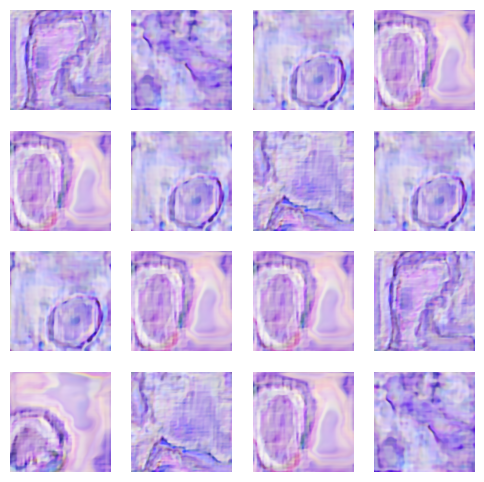

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)